# **Working memory training**: Motion and outliers control

Step 0: Loading libraries and basic settings
----------------------------------------

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("..")

import os
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from fctools import denoise, figures, stats
from nistats.design_matrix import make_first_level_design_matrix

# Matplotlib settings
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
plt.rcParams['font.family'] = 'Helvetica'

small = 25
medium = 25
bigger = 25

plt.rc('font', size=small)          # controls default text sizes
plt.rc('axes', titlesize=small)     # fontsize of the axes title
plt.rc('axes', linewidth=2.2)
plt.rc('axes', labelsize=medium)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small)    # fontsize of the tick labels
plt.rc('legend', fontsize=small)    # legend fontsize
plt.rc('figure', titlesize=bigger)  # fontsize of the figure title
plt.rc('lines', linewidth=2.2, color='gray')

Step 1: Data preparation
----------------------------------------

In [2]:
# Setting main input directory
top_dir = '/media/finc/Elements/LearningBrain_fmriprep/'
out_dir = '/home/finc/Dropbox/Projects/LearningBrain/figures/'

# Selecting subjects who finished the study
groups = pd.read_csv('../data/behavioral/group_assignment.csv')
trained = (groups.group == 'Experimental') | (groups.group == 'Control')
trained_subs = groups[trained]
subs = trained_subs['sub'].values
print(f'Sample size: {len(subs)}')

# Setting sessions and task names
sess = ['ses-1', 'ses-2', 'ses-3', 'ses-4']
#tasks = ['rest']
tasks = ['dualnback']

# Loading events
events = pd.read_csv('../support/onsets_dualnback.csv')
condition = denoise.get_condition_column(events)
condition['no'] = np.arange(len(condition))
condition.head()

Sample size: 46


/home/finc/anaconda3/lib/python3.7/site-packages/nistats/utils.py:276: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


,condition,no
0,intro,0
1,intro,1
2,1-back,2
3,1-back,3
4,1-back,4


Step 2: Looping over subjects and merging their confound files
-----------------------------------------------------------------

In [3]:
tasks = ['rest', 'dualnback']
confounds = pd.DataFrame()

for sub in subs:
    for ses in sess:
        for task in tasks:
            
            # Getting directory/file names
            sub_dir = f'{top_dir}{sub}/{ses}/func/'
            sub_name = f'{sub}_{ses}_task-{task}' 
            
            # Loading confound data
            confounds_path1 = f'{sub_dir}{sub_name}_bold_confounds_clean_acompcor.csv'
            confounds_path2 = f'{sub_dir}{sub_name}_bold_confounds.tsv'
            
            if not os.path.exists(confounds_path1):
                print(f'{sub}{ses}{task} does not exist')
            else:
            
                conf1 = pd.read_csv(confounds_path1)
                conf1 = pd.DataFrame(conf1, columns =['scrubbing'])
                conf1['sub'] = sub
                conf1['ses'] = ses
                conf1['task'] = task
                conf1['no'] = np.arange(len(conf1))

                conf2 = pd.read_csv(confounds_path2, delimiter = '\t')
                conf2 = pd.DataFrame(conf2, columns =['FramewiseDisplacement'])
                conf2.FramewiseDisplacement[0] = 0
                conf2['no'] = np.arange(len(conf2))

                conf_all = pd.merge(conf1, conf2, on = 'no')
                
                if task == 'rest':
                    conf_all['condition'] = 'rest'
                
                else:
                    conf_all = pd.merge(conf_all, condition, on = 'no')

            confounds = pd.concat((confounds, conf_all))

confounds = pd.merge(confounds, trained_subs, on = 'sub')
confounds = confounds.rename(index=str, columns={"group": "Group", "ses": "Session", "condition": "Condition" })

confounds.to_csv('/home/finc/Dropbox/Projects/LearningBrain/github/LearningBrain_networks/data/neuroimaging/coundfounds_summary.csv', 
                 sep = ',', index = False)
confounds.head()

sub-20ses-2rest does not exist
sub-44ses-2rest does not exist


KeyboardInterrupt: 

In [6]:
# Read confounds from .csv
confounds = pd.read_csv('/home/finc/Dropbox/Projects/LearningBrain/data/neuroimaging/01-extracted_timeseries/coundfounds_summary.csv')
confounds.head()

,scrubbing,sub,Session,task,no,FramewiseDisplacement,Condition,Group
0,0,sub-01,ses-1,dualnback,0,0.000000,intro,Control
1,0,sub-01,ses-1,dualnback,1,0.087902,intro,Control
2,0,sub-01,ses-1,dualnback,2,0.044173,1-back,Control
3,0,sub-01,ses-1,dualnback,3,0.071255,1-back,Control
4,0,sub-01,ses-1,dualnback,4,0.071543,1-back,Control


Step 3: Summarizing pandas dataframe
--------------------------------------

In [8]:
f = {'scrubbing':['sum'], 'FramewiseDisplacement':['mean']}

# Total
outlier_all = confounds.groupby(['sub','Session','Group','task']).agg(f).reset_index()

outlier_all['OutlierPerc'] = [((row.scrubbing['sum']/340)*100) if row.task[0] == 'dualnback' else ((row.scrubbing['sum']/305)*100) for i, row in outlier_all.iterrows()]

#outlier_all['OutlierPerc'] = (outlier_all.scrubbing['sum']/340)*100
outlier_all['FD'] = outlier_all.FramewiseDisplacement['mean']

# Grouped by condition
outlier_cond = confounds.groupby(['sub','Session','Group', 'Condition']).agg(f).reset_index()
outlier_cond['OutlierPerc'] = (outlier_cond.scrubbing['sum']/150)*100
outlier_cond['FD'] = outlier_cond.FramewiseDisplacement['mean']
        
outlier_cond = outlier_cond[outlier_cond.Condition != 'intro']
outlier_all

,sub,Session,Group,task,scrubbing,FramewiseDisplacement,OutlierPerc,FD
,,,,,sum,mean,,
0,sub-01,ses-1,Control,dualnback,7,0.102797,2.058824,0.102797
1,sub-01,ses-2,Control,dualnback,5,0.116259,1.470588,0.116259
2,sub-01,ses-3,Control,dualnback,18,0.159409,5.294118,0.159409
3,sub-01,ses-4,Control,dualnback,0,0.086909,0.000000,0.086909
4,sub-02,ses-1,Control,dualnback,0,0.057488,0.000000,0.057488
5,sub-02,ses-2,Control,dualnback,1,0.066987,0.294118,0.066987
6,sub-02,ses-3,Control,dualnback,2,0.077015,0.588235,0.077015
7,sub-02,ses-4,Control,dualnback,1,0.068550,0.294118,0.068550
8,sub-04,ses-1,Control,dualnback,3,0.088156,0.882353,0.088156


Step 4: Plotting
-----------------

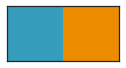

In [115]:
# Setting colors for groups
col_groups = ['#379dbc','#ee8c00']
sns.set_palette(col_groups)
sns.palplot(sns.color_palette(col_groups))

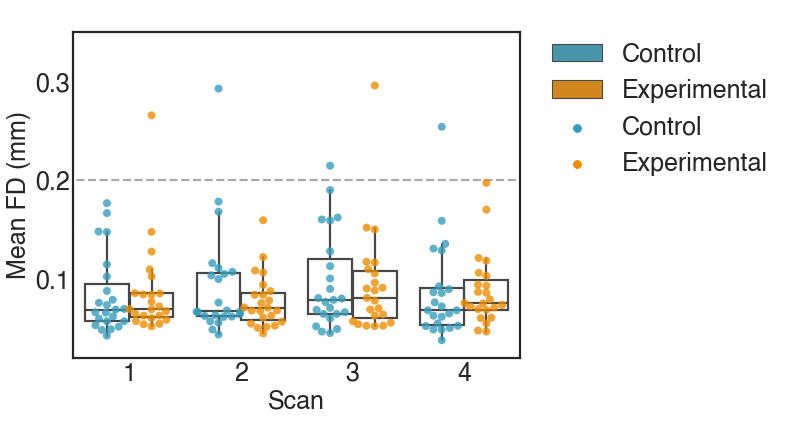

In [116]:
# Plotting mean total framewise displacement (FD)
ax = figures.swarm_box_plot(x="Session", y="FD", hue = 'Group', data = outlier_all[outlier_all.task == 'dualnback'])
ax.set(title=' ')
ax.set(ylabel='Mean FD (mm)')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.hlines(0.2, -1, 4, colors='darkgray', linestyles ='dashed')
plt.setp(ax.spines.values(), linewidth=2.2)
plt.ylim(0.02, 0.35)  

plt.savefig(f'{out_dir}fig_S1a.pdf', bbox_inches="tight", dpi=300)

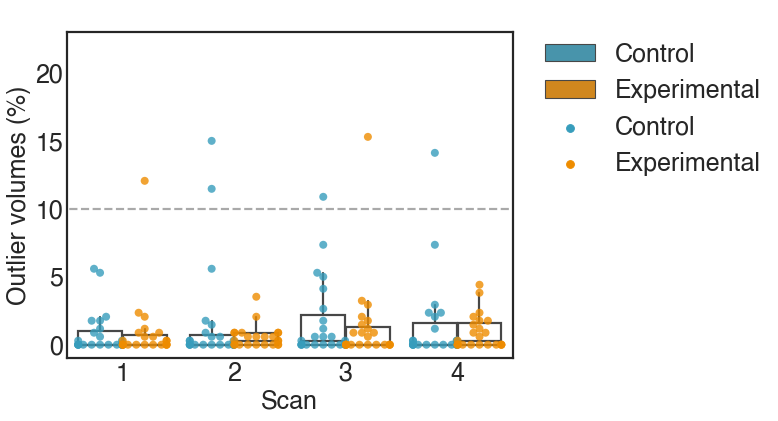

In [43]:
# Plotting total percent of outlier scans
ax = figures.swarm_box_plot(x="Session", y="OutlierPerc", hue = 'Group', data =  outlier_all[outlier_all.task == 'dualnback'])
ax.set(title=' ')
ax.set(ylabel='Outlier volumes (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.hlines(10, -1, 4, colors='darkgray', linestyles ='dashed')
plt.setp(ax.spines.values(), linewidth=2.2)
plt.ylim(-1, 23) 
plt.savefig(f'{out_dir}fig_S1b.pdf', bbox_inches="tight", dpi=300)

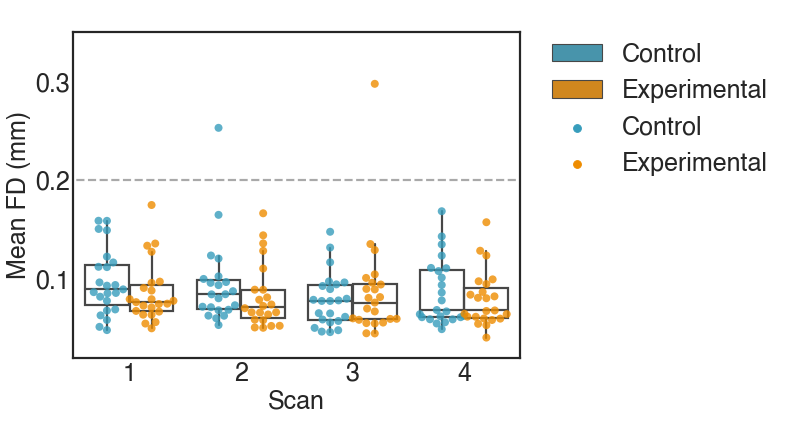

In [122]:
# Plotting mean total framewise displacement (FD)
ax = figures.swarm_box_plot(x="Session", y="FD", hue = 'Group', data = outlier_all[outlier_all.task == 'rest'])
ax.set(title=' ')
ax.set(ylabel='Mean FD (mm)')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.hlines(0.2, -1, 4, colors='darkgray', linestyles ='dashed')
plt.setp(ax.spines.values(), linewidth=2.2)
plt.ylim(0.02, 0.35)  

plt.savefig(f'{out_dir}fig_S1a.pdf', bbox_inches="tight", dpi=300)

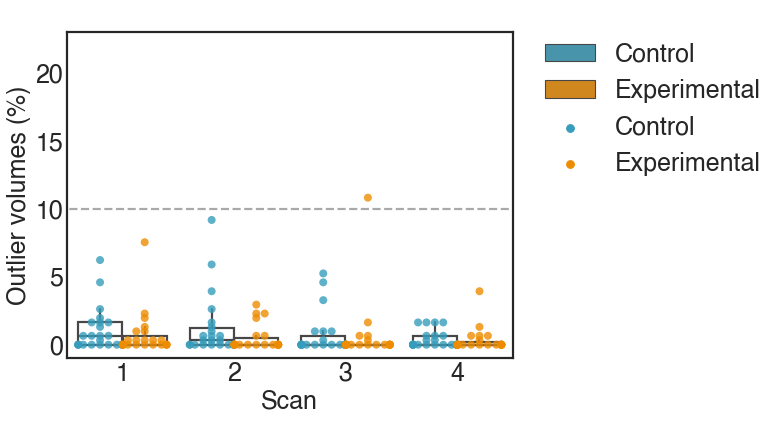

In [121]:
# Plotting total percent of outlier scans
ax = figures.swarm_box_plot(x="Session", y="OutlierPerc", hue = 'Group', data =  outlier_all[(outlier_all.task == 'rest')])
ax.set(title=' ')
ax.set(ylabel='Outlier volumes (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.hlines(10, -1, 4, colors='darkgray', linestyles ='dashed')
plt.setp(ax.spines.values(), linewidth=2.2)
plt.ylim(-1, 23) 
plt.savefig(f'{out_dir}fig_S1b.pdf', bbox_inches="tight", dpi=300)

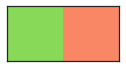

In [32]:
#--- setting colors for conditions

col_cond = ['#88d958','#f98766']
sns.set_palette(col_cond)
sns.palplot(sns.color_palette(col_cond))

In [33]:
outlier_cond.head()

,sub,Session,Group,Condition,scrubbing,FramewiseDisplacement,OutlierPerc,FD
,,,,,sum,mean,,
0,sub-01,ses-1,Control,1-back,1,0.089873,0.666667,0.089873
1,sub-01,ses-1,Control,2-back,3,0.098010,2.000000,0.098010
3,sub-01,ses-2,Control,1-back,2,0.117453,1.333333,0.117453
4,sub-01,ses-2,Control,2-back,1,0.101198,0.666667,0.101198
6,sub-01,ses-3,Control,1-back,5,0.145274,3.333333,0.145274


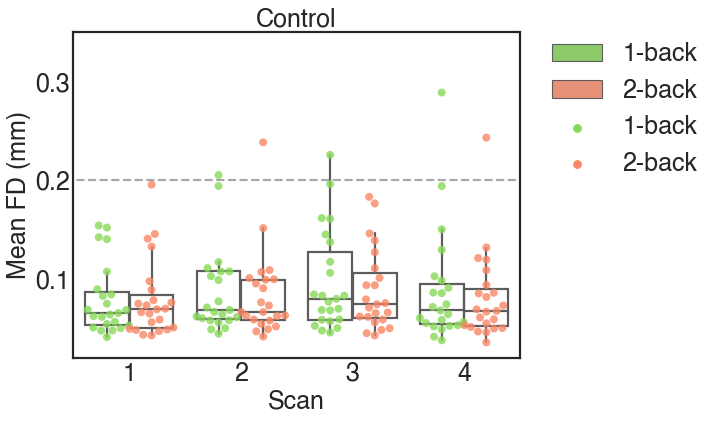

In [34]:
# Plotting mean framewise displacement (FD) for each condition: Control
ax = figures.swarm_box_plot(x="Session", y="FD", hue = 'Condition', data = outlier_cond[outlier_cond.Group == 'Control'])
ax.set(title='Control')
ax.set(ylabel='Mean FD (mm)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.hlines(0.2, -1, 4, colors='darkgray', linestyles ='dashed')
plt.ylim(0.02, 0.35)  
plt.setp(ax.spines.values(), linewidth=2.2)
plt.savefig(f'{out_dir}fig_S1c.pdf', bbox_inches="tight", dpi=300)

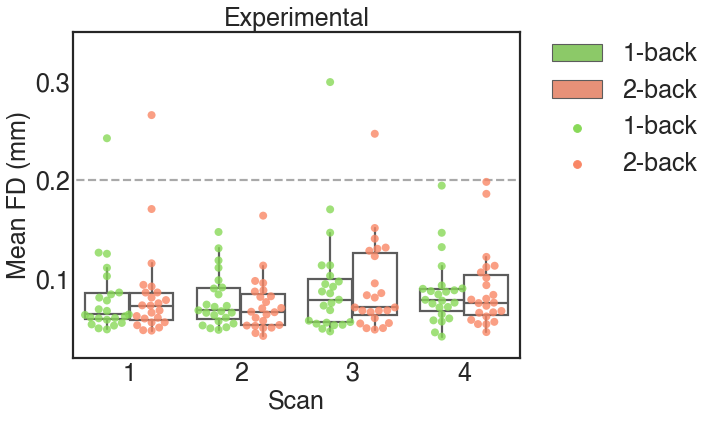

In [36]:
# Plotting mean framewise displacement (FD) for each condition: Control
ax = figures.swarm_box_plot(x="Session", y="FD", hue = 'Condition', data = outlier_cond[outlier_cond.Group == 'Experimental'])
ax.set(title='Experimental')
ax.set(ylabel='Mean FD (mm)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.hlines(0.2, -1, 4, colors='darkgray', linestyles ='dashed')
plt.setp(ax.spines.values(), linewidth=2.2)
plt.ylim(0.02, 0.35)  
plt.savefig(f'{out_dir}fig_S1d.pdf', bbox_inches="tight", dpi=300)

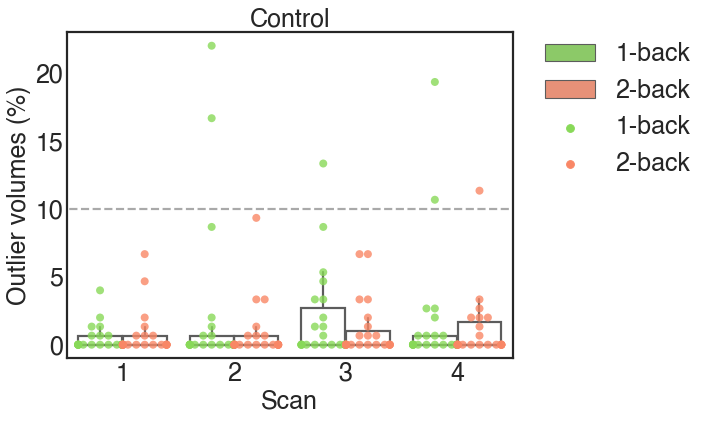

In [37]:
# Plotting % outlier scans for each condition: Control
ax = figures.swarm_box_plot(x="Session", y="OutlierPerc", hue = 'Condition', data = outlier_cond[outlier_cond.Group == 'Control'])
ax.set(title='Control')
ax.set(ylabel='Outlier volumes (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.hlines(10, -1, 4, colors='darkgray', linestyles ='dashed')
plt.setp(ax.spines.values(), linewidth=2.2)
plt.ylim(-1, 23) 
plt.savefig(f'{out_dir}fig_S1e.pdf', bbox_inches="tight", dpi=300)


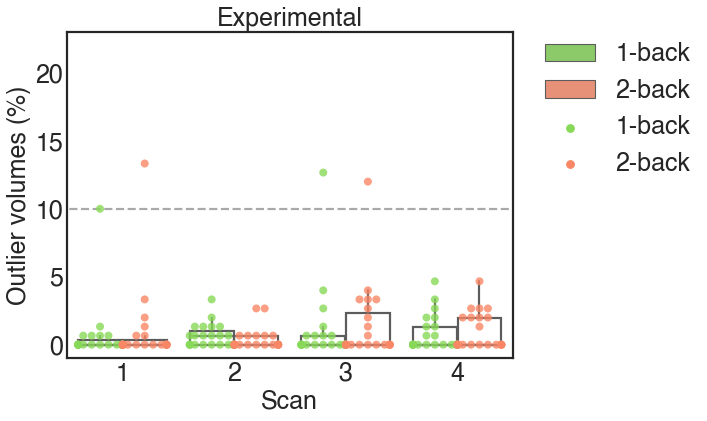

In [16]:
# Plotting % outlier scans for each condition: Control
ax = figures.swarm_box_plot(x="Session", y="OutlierPerc", hue = 'Condition', data = outlier_cond[outlier_cond.Group == 'Experimental'])
ax.set(title='Experimental')
ax.set(ylabel='Outlier volumes (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.hlines(10, -1, 4, colors='darkgray', linestyles ='dashed')
plt.setp(ax.spines.values(), linewidth=2.2)
plt.ylim(-1, 23) 
plt.savefig(f'{out_dir}fig_S1f.pdf', bbox_inches="tight", dpi=300)


Step 5: Deciding which subjects to exclude
-----------------------

In [123]:
outlier_all.head()

,sub,Session,Group,task,scrubbing,FramewiseDisplacement,OutlierPerc,FD
,,,,,sum,mean,,
0,sub-01,ses-1,Control,dualnback,7,0.102797,2.058824,0.102797
1,sub-01,ses-1,Control,rest,5,0.096782,1.639344,0.096782
2,sub-01,ses-2,Control,dualnback,5,0.116259,1.470588,0.116259
3,sub-01,ses-2,Control,rest,1,0.102914,0.327869,0.102914
4,sub-01,ses-3,Control,dualnback,18,0.159409,5.294118,0.159409


In [124]:
criteria = (outlier_all.FD > 0.2) | (outlier_all.OutlierPerc > 10)
excluded = outlier_all[criteria]
ex = np.unique(excluded['sub'].values)

print(f'Subjects to exclude due to FD > 0.2 and % of outlier scans > 10%: {ex}')

excluded

Subjects to exclude due to FD > 0.2 and % of outlier scans > 10%: ['sub-13' 'sub-21' 'sub-23' 'sub-46' 'sub-47' 'sub-50']


,sub,Session,Group,task,scrubbing,FramewiseDisplacement,OutlierPerc,FD
,,,,,sum,mean,,
82,sub-13,ses-2,Control,dualnback,51,0.292881,15.000000,0.292881
84,sub-13,ses-3,Control,dualnback,37,0.214841,10.882353,0.214841
86,sub-13,ses-4,Control,dualnback,48,0.254199,14.117647,0.254199
135,sub-21,ses-1,Experimental,dualnback,41,0.265856,12.058824,0.265856
147,sub-23,ses-3,Experimental,dualnback,52,0.295999,15.294118,0.295999
289,sub-46,ses-2,Control,rest,28,0.253184,9.180328,0.253184
299,sub-47,ses-3,Experimental,rest,33,0.297712,10.819672,0.297712
312,sub-50,ses-2,Control,dualnback,39,0.168320,11.470588,0.168320


In [131]:
criteria_cond = ((outlier_cond.FD > 0.2) | (outlier_cond.OutlierPerc > 10)) & (outlier_cond.Condition != 'rest')
excluded_cond = outlier_cond[criteria_cond]

ex_cond = np.unique(excluded_cond['sub'].values)

print(f'Subjects to exclude due to FD > 0.2 and % of outlier scans > 10%: {ex_cond}')

excluded_cond

Subjects to exclude due to FD > 0.2 and % of outlier scans > 10%: ['sub-13' 'sub-21' 'sub-23' 'sub-50']


,sub,Session,Group,Condition,scrubbing,FramewiseDisplacement,OutlierPerc,FD
,,,,,sum,mean,,
164,sub-13,ses-2,Control,1-back,33,0.360719,22.000000,0.360719
165,sub-13,ses-2,Control,2-back,14,0.238502,9.333333,0.238502
168,sub-13,ses-3,Control,1-back,20,0.225853,13.333333,0.225853
172,sub-13,ses-4,Control,1-back,29,0.288901,19.333333,0.288901
173,sub-13,ses-4,Control,2-back,17,0.243322,11.333333,0.243322
271,sub-21,ses-1,Experimental,1-back,15,0.242636,10.000000,0.242636
272,sub-21,ses-1,Experimental,2-back,20,0.266076,13.333333,0.266076
295,sub-23,ses-3,Experimental,1-back,19,0.299484,12.666667,0.299484
296,sub-23,ses-3,Experimental,2-back,18,0.247164,12.000000,0.247164


In [5]:
to_exclude = ['sub-13', 'sub-21', 'sub-23', 'sub-50']

Step 6: Calculate mean of FD and % of outlier scans
-----------------------

In [6]:
clean_cond = outlier_cond[~outlier_cond['sub'].isin(to_exclude)]
clean_all = outlier_all[~outlier_all['sub'].isin(to_exclude)]

In [30]:
clean_cond.groupby(['Group', 'Session','Condition']).mean()[['Group', 'FD', 'OutlierPerc']]

FD OutlierPerc
                                                    
Group        Session Condition                      
Control      ses-1   1-back     0.073047    0.222222
                     2-back     0.073446    0.444444
             ses-2   1-back     0.080608    0.634921
                     2-back     0.075341    0.317460
             ses-3   1-back     0.086675    1.047619
                     2-back     0.079724    0.571429
             ses-4   1-back     0.073583    0.476190
                     2-back     0.071452    0.507937
Experimental ses-1   1-back     0.074626    0.190476
                     2-back     0.076489    0.380952
             ses-2   1-back     0.078148    0.634921
                     2-back     0.073328    0.380952
             ses-3   1-back     0.082747    0.507937
                     2-back     0.086070    0.984127
             ses-4   1-back     0.086984    0.825397
                     2-back     0.089315    0.920635

In [31]:
clean_all.groupby(['Group', 'Session']).mean()[['Group', 'FD', 'OutlierPerc']]

FD OutlierPerc
                                          
Group        Session                      
Control      ses-1    0.078066    0.574230
             ses-2    0.080525    0.560224
             ses-3    0.086840    1.064426
             ses-4    0.075071    0.574230
Experimental ses-1    0.078692    0.420168
             ses-2    0.077540    0.588235
             ses-3    0.084885    0.756303
             ses-4    0.089339    0.938375

Step 7: Calculate test statistic to compare groups/sessions/conditions
-----------------------

In [5]:
sess = ['ses-1', 'ses-2', 'ses-3', 'ses-4']
conds = ['1-back', '2-back']
groups = ['Control', 'Experimental']

Comparing conditions

In [10]:
# Differences in FD between conditions for experimental group
stats.ttest_rel_cond('Experimental','FD', data = clean_cond)

,statistic,pval
0,-0.597848,0.556651
1,1.919393,0.069316
2,-0.808793,0.428151
3,-0.716073,0.482224


In [11]:
# Differences in FD between conditions for control group
stats.ttest_rel_cond('Control','FD', data = clean_cond)

,statistic,pval
0,-0.164257,0.871177
1,1.839224,0.080777
2,2.687454,0.014161
3,0.508172,0.616892


In [12]:
# Differences in % of oultier scans between conditions for experimental group
stats.ttest_rel_cond('Experimental','OutlierPerc', data = clean_cond)

,statistic,pval
0,-1.300054,0.208366
1,1.562929,0.133755
2,-1.825742,0.082859
3,-0.358825,0.723486


In [13]:
# Differences in % of oultier scans between conditions for control group
stats.ttest_rel_cond('Control','OutlierPerc', data = clean_cond)

,statistic,pval
0,-1.233588,0.231658
1,1.156243,0.261207
2,2.151657,0.043823
3,-0.181369,0.857903


Comparing sessions 
---------------------------------

In [29]:
stats.ttest_rel_sess('Experimental','FD', data = clean_all)[:,:,0]

array([[        nan,  0.19845373, -1.0692409 , -1.17607465],
       [-0.19845373,         nan, -1.8061182 , -1.53000158],
       [ 1.0692409 ,  1.8061182 ,         nan, -0.53652127],
       [ 1.17607465,  1.53000158,  0.53652127,         nan]])

In [32]:
stats.ttest_rel_sess('Experimental','OutlierPerc', data = clean_all)[:,:,0]

array([[        nan, -0.77363024, -1.67910192, -1.49956192],
       [ 0.77363024,         nan, -0.66605024, -0.99499779],
       [ 1.67910192,  0.66605024,         nan, -0.50587104],
       [ 1.49956192,  0.99499779,  0.50587104,         nan]])

In [33]:
stats.ttest_rel_sess('Control','FD', data = clean_all)[:,:,0]

array([[        nan, -0.46024797, -1.07523965,  0.5486624 ],
       [ 0.46024797,         nan, -0.94951099,  1.46362197],
       [ 1.07523965,  0.94951099,         nan,  1.89452319],
       [-0.5486624 , -1.46362197, -1.89452319,         nan]])

In [31]:
stats.ttest_rel_sess('Control','OutlierPerc', data = clean_all)[:,:,0]

array([[            nan,  5.34828187e-02, -1.28489042e+00,
        -8.93449555e-17],
       [-5.34828187e-02,             nan, -1.58665766e+00,
        -6.71913141e-02],
       [ 1.28489042e+00,  1.58665766e+00,             nan,
         1.37546061e+00],
       [ 8.93449555e-17,  6.71913141e-02, -1.37546061e+00,
                    nan]])

Comparing groups 
---------------------------------

In [18]:
stats.ttest_ind_groups('FD', clean_all)

,statistic,pval
0,0.066540,0.947280
1,-0.324753,0.747061
2,-0.184843,0.854286
3,1.387678,0.172917


In [19]:
stats.ttest_ind_groups('OutlierPerc', clean_all)

,statistic,pval
0,-0.502655,0.617963
1,0.084478,0.933098
2,-0.707802,0.483172
3,1.027179,0.310508
